In [16]:
import torch
import cv2
import pandas as pd
import numpy as np
import config
import utils
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
resize = 96

In [17]:
def train_test_split(csv_path, split):
    df_data = pd.read_csv(csv_path)
    # drop all the rows with missing values
    df_data = df_data.dropna()
    len_data = len(df_data)
    # calculate the validation data sample length
    valid_split = int(len_data * split)
    # calculate the training data samples length
    train_split = int(len_data - valid_split)
    training_samples = df_data.iloc[:train_split][:]
    valid_samples = df_data.iloc[-valid_split:][:]
    print(f"Training sample instances: {len(training_samples)}")
    print(f"Validation sample instances: {len(valid_samples)}")
    return training_samples, valid_samples

In [18]:
class FaceKeypointDataset(Dataset):
    def __init__(self, samples):
        self.data = samples
        # get the image pixel column only
        self.pixel_col = self.data.Image
        #store the pixel values after extracting them from the Image column
        self.image_pixels = []
        for i in tqdm(range(len(self.data))):
            #pixel values by space as they are space separated in the CSV file as well
            img = self.pixel_col.iloc[i].split(' ')
            self.image_pixels.append(img)
        self.images = np.array(self.image_pixels, dtype='float32')
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # reshape the images into their original 96x96 dimensions
        image = self.images[index].reshape(96, 96)
        #extract the original height and width of the images 
        orig_w, orig_h = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (resize, resize))
        # again reshape to add grayscale channel format
        image = image.reshape(resize, resize, 1)
        image = image / 255.0
        # transpose for getting the channel size to index 0
        image = np.transpose(image, (2, 0, 1))
        # get the keypoints
        keypoints = self.data.iloc[index][:30]
        keypoints = np.array(keypoints, dtype='float32')
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [resize / orig_w, resize / orig_h]
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

In [20]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{config.ROOT_PATH}/training/training.csv",
                                                   config.TEST_SPLIT)
# initialize the dataset - `FaceKeypointDataset()`
print('\n-------------- PREPARING DATA --------------\n')
train_data = FaceKeypointDataset(training_samples)
valid_data = FaceKeypointDataset(valid_samples)
print('\n-------------- DATA PREPRATION DONE --------------\n')
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=False)

 17%|█▋        | 293/1712 [00:00<00:00, 2476.64it/s]

Training sample instances: 1712
Validation sample instances: 428

-------------- PREPARING DATA --------------



100%|██████████| 428/428 [00:00<00:00, 2856.41it/s]


-------------- DATA PREPRATION DONE --------------



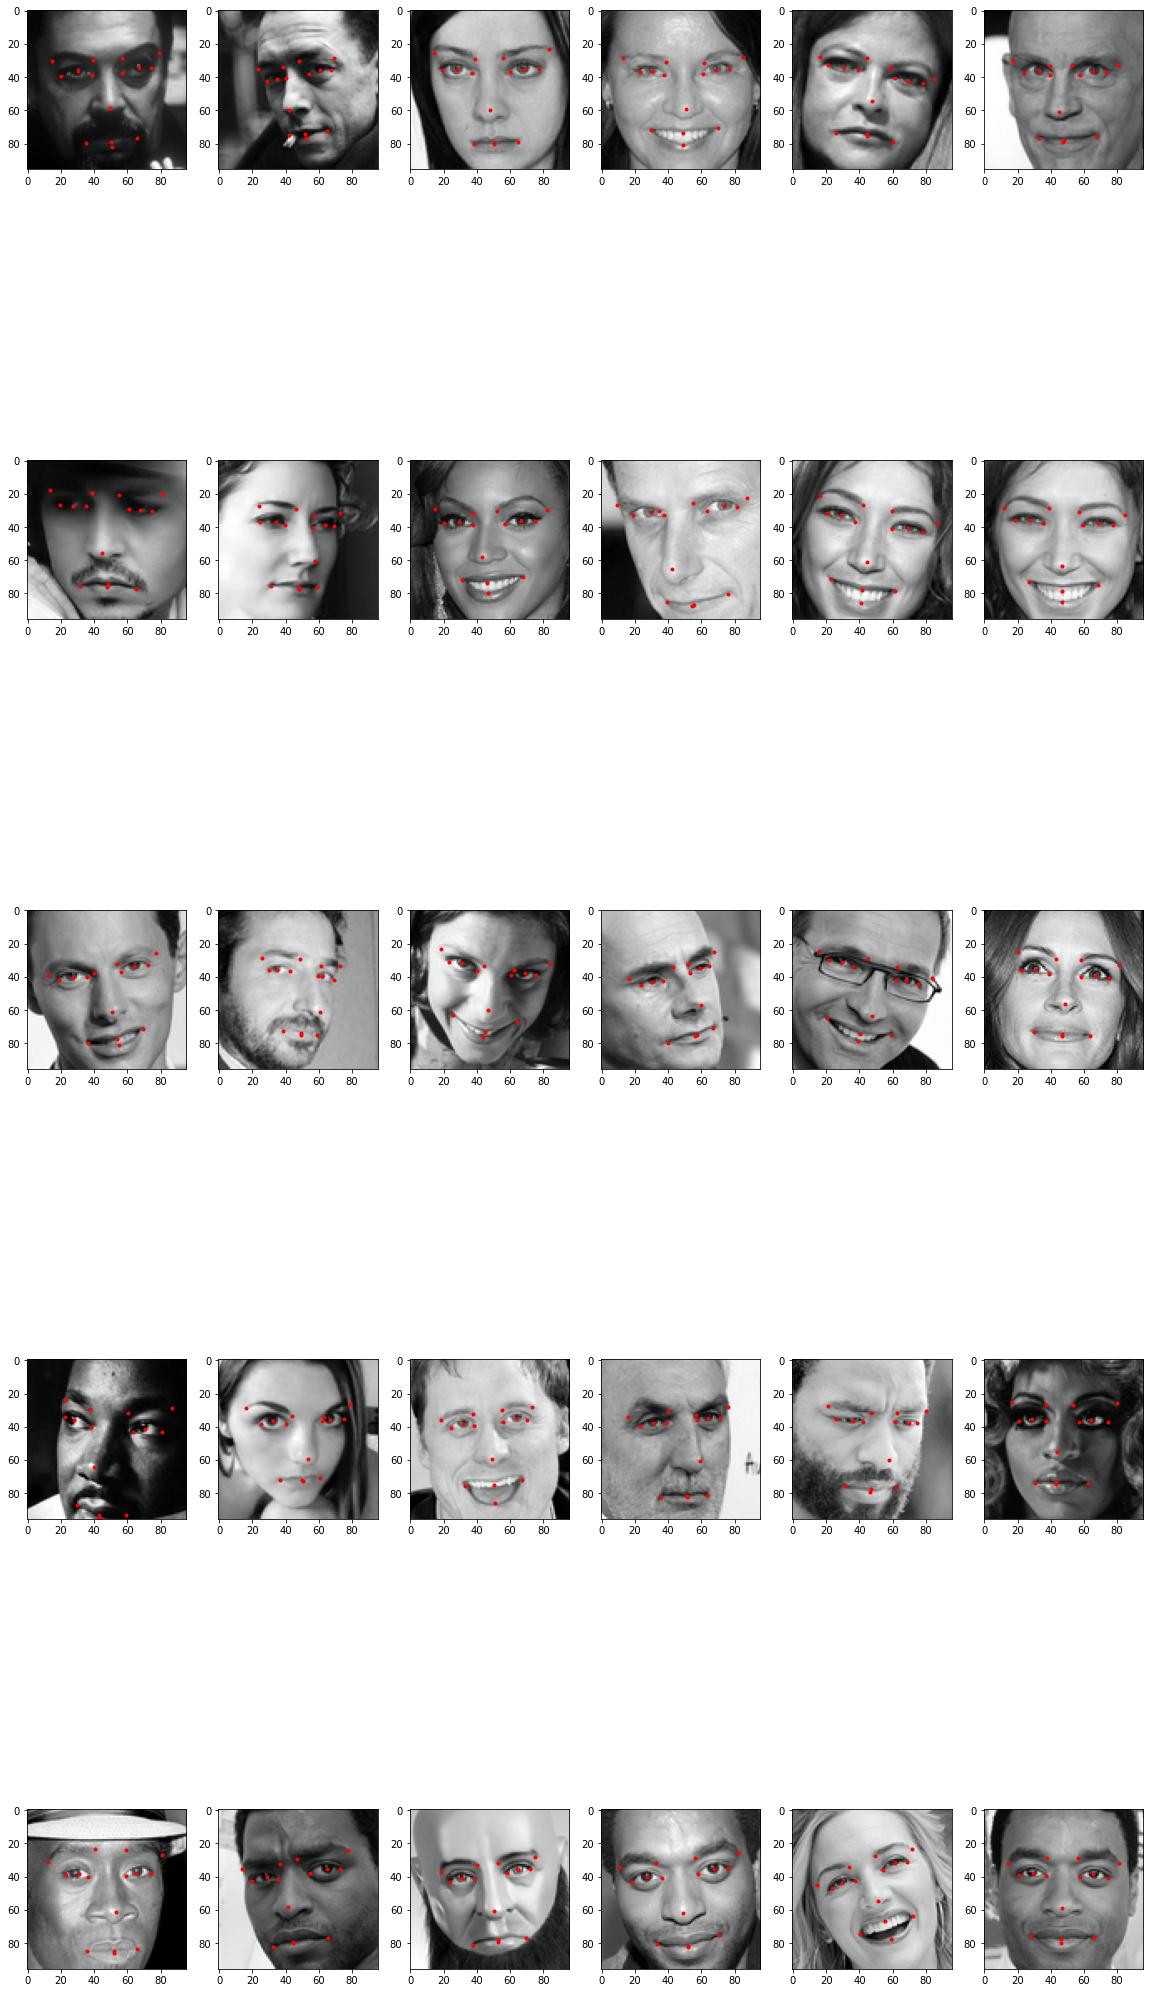

In [15]:
#This will show the faces and the keypoints just before training.
if config.SHOW_DATASET_PLOT:
    utils.dataset_keypoints_plot(valid_data)